In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 0

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

setGPU: Setting GPU to: 0


Using TensorFlow backend.


In [3]:
#!pip install -q keract 
import collections
import numpy
from keract import get_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import time
from IPython.display import SVG

In [4]:
# LOAD DATA
num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Loading models

In [5]:
# LOAD huge MODELS
import sys
sys.path.insert(0, "../")
from models import VGG16_Vanilla, VGG16
# Simply loading both the initial and finals weights of our models

modelA = VGG16(input_shape=(32,32,3), num_classes=10, weight_decay=0.005) #with less generalization
modelB = VGG16_Vanilla(input_shape=(32,32,3), num_classes=10) #with more generalization

# Initial and final weights
W_i = collections.defaultdict(list)
W_f = collections.defaultdict(list)

modelA.load_weights("../weights/final/vgg16.h5")
modelB.load_weights("../weights/final/vgg16_vanilla.h5")

sgd = optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True)
modelA.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelB.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [6]:
# EVALUATION
# Final evaluation of the models
scoresA = modelA.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresA[0])
print('Test accuracy:', scoresA[1])
print("Model A CNN Error: %.2f%%" % (100-scoresA[1]*100))
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("Model B CNN Error: %.2f%%" % (100-scoresB[1]*100))

10000/10000 [==============================] - 5s 499us/step
Test loss: 3.709580239868164
Test accuracy: 0.2978
Model A CNN Error: 70.22%
10000/10000 [==============================] - 3s 273us/step
Test loss: 5.971178263854981
Test accuracy: 0.2222
Model B CNN Error: 77.78%


### Mutual Information
On regarde l'information mutuelle arrondie à des binaires.

In [7]:
# On regarde l'activation des neurones pour un echantillon test
Echantillon = []
nombreDImagesDActivation = 50
NombrePairs = 10000#0
choix = numpy.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_test[choix, :, : , :]

#Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IMA = get_activations(modelA, Echantillon)
IMB = get_activations(modelB, Echantillon)

In [8]:
# on affiche les noms des differentes couches
print(IMA.keys())
print('\n')
print(IMB.keys())

dict_keys(['max_pooling2d_5/MaxPool:0', 'activation_5/Relu:0', 'activation_8/Relu:0', 'conv2d_13/BiasAdd:0', 'conv2d_6/BiasAdd:0', 'batch_normalization_6/cond/Merge:0', 'max_pooling2d_1/MaxPool:0', 'activation_1/Relu:0', 'activation_15/Softmax:0', 'max_pooling2d_3/MaxPool:0', 'conv2d_10/BiasAdd:0', 'activation_2/Relu:0', 'conv2d_4/BiasAdd:0', 'batch_normalization_12/cond/Merge:0', 'conv2d_3/BiasAdd:0', 'conv2d_11/BiasAdd:0', 'activation_3/Relu:0', 'batch_normalization_2/cond/Merge:0', 'batch_normalization_13/cond/Merge:0', 'activation_14/Relu:0', 'activation_13/Relu:0', 'conv2d_9/BiasAdd:0', 'activation_7/Relu:0', 'activation_12/Relu:0', 'batch_normalization_3/cond/Merge:0', 'conv2d_7/BiasAdd:0', 'batch_normalization_10/cond/Merge:0', 'activation_10/Relu:0', 'dense_2/BiasAdd:0', 'flatten_1/Reshape:0', 'batch_normalization_4/cond/Merge:0', 'activation_9/Relu:0', 'max_pooling2d_2/MaxPool:0', 'conv2d_5/BiasAdd:0', 'activation_11/Relu:0', 'conv2d_2/BiasAdd:0', 'batch_normalization_1/cond/M

In [9]:
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [10]:
List_of_Layers_A = [
'conv2d_1/BiasAdd:0', 
'conv2d_2/BiasAdd:0',
'max_pooling2d_1/MaxPool:0',
'conv2d_3/BiasAdd:0', 
'conv2d_4/BiasAdd:0', 
'max_pooling2d_2/MaxPool:0',
'conv2d_5/BiasAdd:0', 
'conv2d_6/BiasAdd:0',  
'conv2d_7/BiasAdd:0', 
'max_pooling2d_3/MaxPool:0', 
'conv2d_8/BiasAdd:0',  
'conv2d_9/BiasAdd:0', 
'conv2d_10/BiasAdd:0', 
'max_pooling2d_4/MaxPool:0', 
'conv2d_11/BiasAdd:0',    
'conv2d_12/BiasAdd:0',
'conv2d_13/BiasAdd:0', 
'max_pooling2d_5/MaxPool:0', 
'dense_1/BiasAdd:0', 
'dense_2/BiasAdd:0', 
 ]

List_of_Layers_B = [
'conv2d_14/BiasAdd:0', 
'conv2d_15/BiasAdd:0',
'max_pooling2d_6/MaxPool:0',
'conv2d_16/BiasAdd:0', 
'conv2d_17/BiasAdd:0', 
'max_pooling2d_7/MaxPool:0',
'conv2d_18/BiasAdd:0', 
'conv2d_19/BiasAdd:0',  
'conv2d_20/BiasAdd:0', 
'max_pooling2d_8/MaxPool:0', 
'conv2d_21/BiasAdd:0',  
'conv2d_22/BiasAdd:0', 
'conv2d_23/BiasAdd:0', 
'max_pooling2d_9/MaxPool:0', 
'conv2d_24/BiasAdd:0',    
'conv2d_25/BiasAdd:0',
'conv2d_26/BiasAdd:0', 
'max_pooling2d_10/MaxPool:0', 
'dense_3/BiasAdd:0', 
'dense_4/BiasAdd:0', 
 ]

In [11]:
def MI(IM, nameOfTheLayer):
    
    #count of the number of MI = 1
    CountMI1 = 0
    #count the number of pathologic neurons (only 1 or 0)
    pathologicCount = 0
    MutualInfoWithoutOnes = []
    
    #nombre d'images utilisées pour l'activation:
    numActivations = len(IM[nameOfTheLayer])
    
    #nombre de neurones dans la couche
    #numNeurons = len(IM[nameOfTheLayer][0])
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    print('number of neurons for the layer: '+str(numNeurons))

    #print(IM[nameOfTheLayer])
    #plt.imshow(IM[nameOfTheLayer])
    #plt.show()
    
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NeuronsSelected = numpy.zeros((NombrePairs,2))  # initialize

    for i in range(NombrePairs):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)  # on prend 2 neurones selectionnées aleatoirement
        # les 2 neurones doivent être différents
        while NeuronsSelected[i][0] == NeuronsSelected[i][1]:
            NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)

    #print(NeuronsSelected[56])
    #print(NeuronsSelected[56][0])
    
    MutualInfo = numpy.zeros((NombrePairs,1))  # initialization des resultats

    for j in range(NombrePairs):
        X = numpy.zeros((numActivations,1))  # initialization du vecteur X
        Y = numpy.zeros((numActivations,1))  # initialization du vecteur y

        i = 0
        for activation in IM[nameOfTheLayer]:   # pour chaque element de l'echantillon (= chaque activation)
            #print(activation)
            #print(numpy.size(activation))
            activation = activation.flatten()
            #print(activation)
            X[i] = activation[int(NeuronsSelected[j][0])-1] # on regarde l'activation du neurone selectionné
            Y[i] = activation[int(NeuronsSelected[j][1])-1]

            # On binarise : RELU
            if X[i] > 0:
                X[i] = 1
            else:
                X[i] = 0
            if Y[i] > 0:
                Y[i] = 1
            else:
                Y[i] = 0

            i = i+1

        X = X.flatten()
        Y = Y.flatten()
        #print(X)
        #print(Y)

        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,Y,average_method='max')
        #print(MutualInfo[j])
        if (MutualInfo[j])==1.:
            CountMI1 = CountMI1 + 1
            if all([ v == 0 for v in X ]) or all([ v == 0 for v in Y ]) or all([ v == 1 for v in X ]) or all([ v == 1 for v in Y ]):
                pathologicCount = pathologicCount + 1
        else:
            MutualInfoWithoutOnes.append(MutualInfo[j])
            
    return MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount

number of images used for see the activations : 50

number of pairs of neurons analyzed: 10000

 Model A :

couche : conv2d_1/BiasAdd:0
number of neurons for the layer: 65536
MI mean:  0.8786371374875834
pathologic Count:  8783  on  8784  MI_1 =  99.98861566484517 %

couche : conv2d_2/BiasAdd:0
number of neurons for the layer: 65536
MI mean:  0.11288255897720444
pathologic Count:  1010  on  1012  MI_1 =  99.80237154150198 %

couche : max_pooling2d_1/MaxPool:0
number of neurons for the layer: 16384
MI mean:  0.18481241947994448
pathologic Count:  1755  on  1759  MI_1 =  99.77259806708358 %

couche : conv2d_3/BiasAdd:0
number of neurons for the layer: 32768
MI mean:  0.2599055855488415
pathologic Count:  2523  on  2524  MI_1 =  99.96038034865293 %

couche : conv2d_4/BiasAdd:0
number of neurons for the layer: 32768
MI mean:  0.21537903811607104
pathologic Count:  2055  on  2068  MI_1 =  99.37137330754352 %

couche : max_pooling2d_2/MaxPool:0
number of neurons for the layer: 8192
MI mean: 

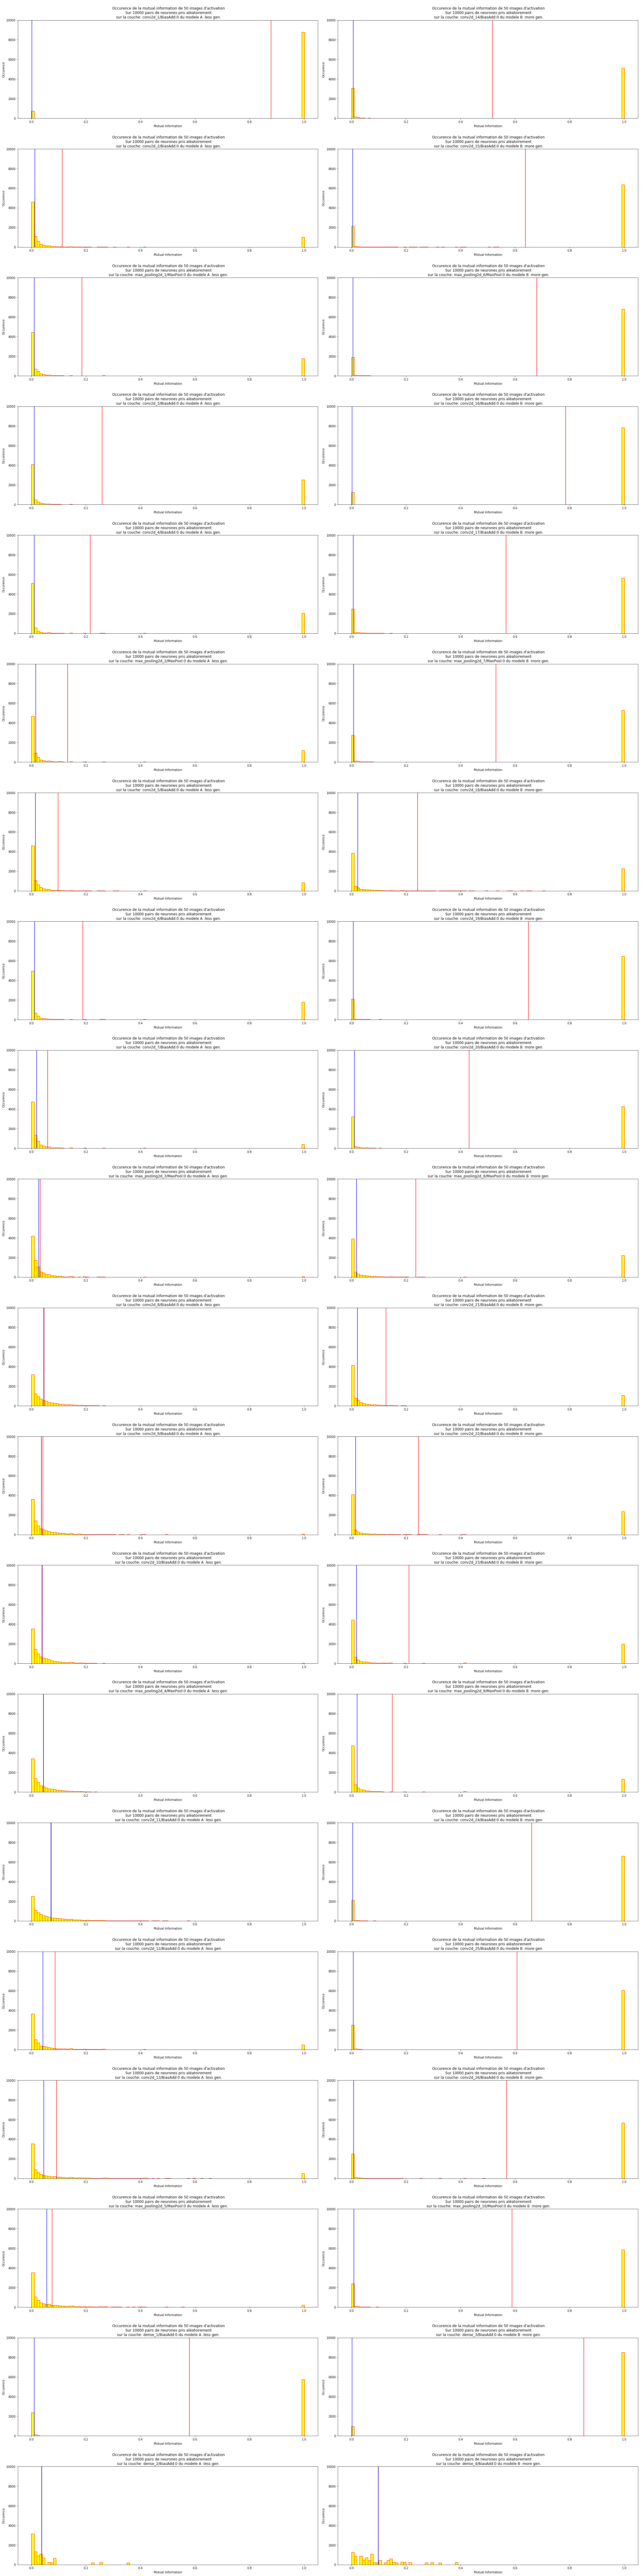

In [12]:
VarPathA = []
VarPathB = []

print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')
print('number of pairs of neurons analyzed: '+str(NombrePairs))

fig = plt.figure(figsize=(30, 300))
plt.ylim(top=1000)

# model A sans generalisation a gauche
print('\n Model A :\n')
i = 1
for layer in List_of_Layers_A:
    #nom de la couche
    print('couche :', str(layer))
    #MI
    MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount = MI(IMA, layer)
    #plot
    plt.subplot(len(IMA), 2, i)
    plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
    plt.xlabel('Mutual Information')
    plt.ylabel('Occurence')
    plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele A :less gen.')
    plt.tight_layout()
    plt.ylim(top=NombrePairs)
    plt.axvline(x=numpy.mean(MutualInfo), color='red')
    plt.axvline(x=numpy.mean(MutualInfoWithoutOnes), color='blue')
    print('MI mean: ', str(numpy.mean(MutualInfo)))
    if CountMI1 != 0:
        VarPathA.append(pathologicCount/CountMI1)
    else:
        VarPathA.append(0)
    print('pathologic Count: ', str(pathologicCount),' on ',str(CountMI1),' MI_1 = ',str(VarPathA[-1]*100),'%\n')
    i = i + 2

# model B avec generalisation a droite
print('\n Model B :\n')
i = 2
for layer in List_of_Layers_B:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        #MI
        MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount = MI(IMB, layer)
        #plot
        plt.subplot(len(IMA), 2, i)
        plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
        plt.xlabel('Mutual Information')
        plt.ylabel('Occurence')
        plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele B :more gen.')
        plt.tight_layout()
        plt.ylim(top=NombrePairs)
        plt.axvline(x=numpy.mean(MutualInfo), color='red')
        plt.axvline(x=numpy.mean(MutualInfoWithoutOnes), color='blue')
        print('MI mean: ', str(numpy.mean(MutualInfo)))
        if CountMI1 != 0:
            VarPathB.append(pathologicCount/CountMI1)
        else:
            VarPathB.append(0)
        print('pathologic Count: ', str(pathologicCount),' on ',str(CountMI1),' MI_1 = ',str(VarPathB[-1]*100),'%\n')
        i = i + 2
plt.show()

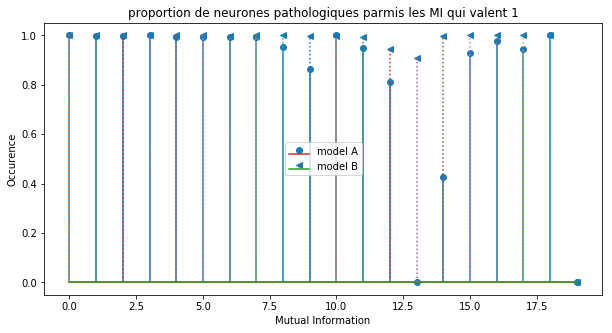

In [14]:
fig = plt.figure(figsize=(10, 5))
markerlineA, stemlinesA, baselineA = plt.stem(VarPathA)
markerlineB, stemlinesB, baselineB = plt.stem(VarPathB, linefmt=':', markerfmt="<", basefmt='C2-')
plt.legend(['model A', 'model B'])
plt.xlabel('Mutual Information')
plt.ylabel('Occurence')
plt.title('proportion de neurones pathologiques parmis les MI qui valent 1')
plt.show()

* On a donc pour les couches convolutives: + de redondances d'informations pour la premiere couche d'un NN qui generalise moins.
*   La redondance est faible pour toutes les couches au milieu, de manière assez similaire aux 2 modeles.
Pour les 2 dernieres couches denses, il y a redondance legere et moyenne pour les couches du modele qui generalise moins bien.
*    Et il y a peu de redondance et 100% pour les couches du modeles qui generalise mieux.
* -> on peut donc dire que la diversité d'information du modele qui generalise mieux est plus importante, et de plus,
    la classification se fait plus facilement (lors de la premiere couche dense #classificationLineaire??)

* ajout de la detection de neurones pathologiques: on remarque que la plupart des neurones avec une MI de 1 sont pathologiques (renvoient que des 1 ou que des 0).
* TODO: analyser quand on ignore ces neurones pathologiques, et veulent dire ces neurones pathologiques